In [28]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.cuda.nvtx as nvtx
from torchvision import datasets
import matplotlib.pyplot as plt
import math
import random
import copy
import sys
import time
from IPython.display import clear_output

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
torch.manual_seed(2244)

theta = [0.1, 1, 1.8, 2]

def gaussian(x, mu):
    return (1 / (0.3 * math.sqrt(2 * math.pi))) * (math.e ** ((-1/2) * (((x - mu) / 0.3)) ** 2))

def gaussian_mixture(x):
    return gaussian(x, theta[0]) + gaussian(x, theta[1]) + gaussian(x, theta[2]) + gaussian(x, theta[3])

batch_size = 400000

class DE_NN(nn.Module):
    def __init__(self, NP, CR, F):
        super(DE_NN, self).__init__()
        lin1s = nn.init.kaiming_uniform_(torch.empty((NP, 4, 1), requires_grad=False).to(device, non_blocking=True))
        lin2s = nn.init.kaiming_uniform_(torch.empty((NP, 8, 4), requires_grad=False).to(device, non_blocking=True))
        lin3s = nn.init.kaiming_uniform_(torch.empty((NP, 4, 8), requires_grad=False).to(device, non_blocking=True))
        lin4s = nn.init.kaiming_uniform_(torch.empty((NP, 1, 4), requires_grad=False).to(device, non_blocking=True))
        self.layers = [lin1s, lin2s, lin3s, lin4s]
        bias1 = nn.init.kaiming_uniform_(torch.empty((NP, 4, 1), requires_grad=False).to(device, non_blocking=True))
        bias2 = nn.init.kaiming_uniform_(torch.empty((NP, 8, 1), requires_grad=False).to(device, non_blocking=True))
        bias3 = nn.init.kaiming_uniform_(torch.empty((NP, 4, 1), requires_grad=False).to(device, non_blocking=True))
        bias4 = nn.init.kaiming_uniform_(torch.empty((NP, 1, 1), requires_grad=False).to(device, non_blocking=True))
        self.biases = [bias1, bias2, bias3, bias4]
        self.NP = NP
        self.CR = CR
        self.F = F
        self.min_l = torch.tensor(float('inf'))
        self.best_model = 0
    def forward_all(self, X, layers, biases):
        # This is just bmm???
        #M = torch.empty((NP, 8, batch_size)).to(device) # l, i, j
        #for l in range(NP):
        #    for i in range(8):
        #        for j in range(batch_size):
        #            total = 0
        #            for k in range(4):
        #                total += self.lin2s[l,i,k] * X[l,k,j]
        #            total += self.bias2[l, i]
        #            M[l,i,j] = total
        #print(torch.sum(torch.relu(M)))
        for i in range(len(layers) - 1):
            X = torch.relu(torch.einsum('lik,lkj->lij', layers[i], X) + biases[i])
        X = torch.einsum('lik,lkj->lij', layers[len(layers) - 1], X) + biases[len(layers) - 1]
        return X
    def forward(self, X):
        for i in range(len(self.layers) - 1):
            X = torch.relu(torch.matmul(self.layers[i][self.best_model], X) + self.biases[i][self.best_model])
        return torch.matmul(self.layers[len(self.layers) - 1][self.best_model], X) + self.biases[len(self.layers) - 1][self.best_model]
    def step(self, X, Y, L, type='param'): # forward pass with candidate i
        nvtx.range_push("forward_1")
        fx = L(self.forward_all(X, self.layers, self.biases), Y).mean(dim = 2)
        nvtx.range_pop()
        nvtx.range_push(f"copy layers")
        y_layers = [self.layers[i].detach().clone() for i in range(len(self.layers))]
        y_biases = [self.biases[i].detach().clone() for i in range(len(self.layers))]
        nvtx.range_pop()
        
        for id in range(self.NP):
            agent_ids = random.sample(range(0, self.NP), 3) # how to efficiently reject self? rej sampling?
            R = random.randint(0, len(self.layers))
            nvtx.range_push(f"updating candidate {id}")
            for i in range(len(self.layers)):
                nvtx.range_push(f"updating layer {i}")
                ri = random.random()
                if ri < self.CR or i == R:
                    y_layers[i][id].copy_(self.layers[i][id] + self.F * (self.layers[i][self.best_model] - self.layers[i][id]) 
                    + self.F * (self.layers[i][agent_ids[0]] - self.layers[i][agent_ids[1]]))
                    y_biases[i][id].copy_(self.biases[i][id] + self.F * (self.biases[i][self.best_model] - self.biases[i][id]) 
                    + self.F * (self.biases[i][agent_ids[0]] - self.biases[i][agent_ids[1]]))
                #y_layers[i][id] *= 0.99
                nvtx.range_pop()
            nvtx.range_pop()

        nvtx.range_push("forward_2")
        fy = L(self.forward_all(X, y_layers, y_biases), Y).mean(dim = 2)
        nvtx.range_pop()

        for id in range(self.NP):
            nvtx.range_push(f"updating model {id}")
            if fy[id] <= fx[id]:
                for i in range(len(self.layers)):
                    self.layers[i][id].copy_(y_layers[i][id])
                    self.biases[i][id].copy_(y_biases[i][id])
                fx[id] = fy[id]
            if fx[id] < self.min_l:
                self.best_model = id
                self.min_l = fx[id]
            nvtx.range_pop()
        # what if we update layers on the CPU, the transfer it to the GPU so we dont incur costs for launching small kernels
        # what if we iteratively compute the forward loss instead of waiting for everything to finish just to hide latency?

Using cuda device


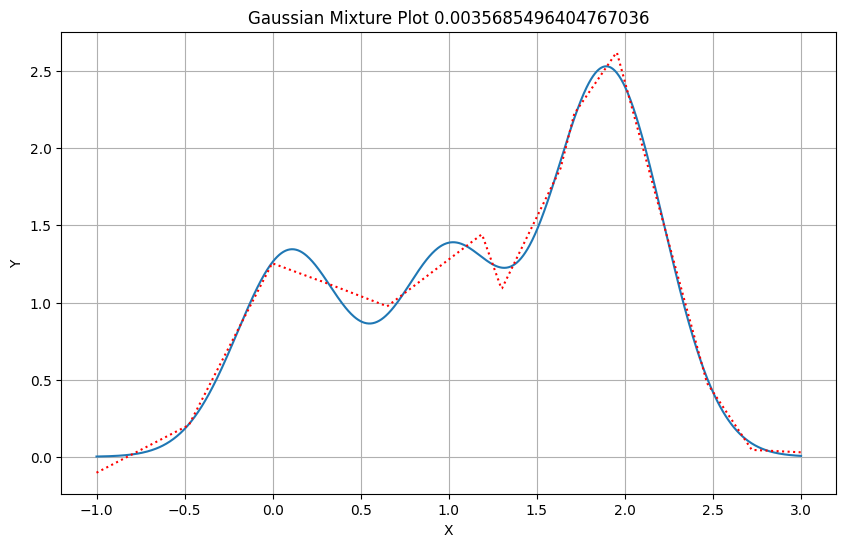

In [29]:
epochs = 2000

NP = 44
CR = 0.9
F = 0.8
X = torch.rand(1, batch_size).to(device) * 5 - 1
Y = gaussian_mixture(X).to(device)

print(X.shape, Y.shape)
X = X.unsqueeze(0).expand(NP, 1, batch_size)
Y = Y.unsqueeze(0).expand(NP, 1, batch_size)
print(X.shape, Y.shape)

model = DE_NN(NP, CR, F).to(device) 
model = torch.compile(model, mode='default')
L = nn.MSELoss(reduction='none')

Y_pred = model.forward_all(X, model.layers, model.biases)
print(Y_pred.shape)


for e in range(epochs):
    model.step(X, Y, L, 'block')
    if e % 5 == 0:
        with torch.no_grad():
            test_X = torch.linspace(-1, 3, 1000).unsqueeze(0)
            test_Y = gaussian_mixture(test_X)
            model_Y = model(test_X.to(device)).cpu()
            # Clear the previous output before plotting
            clear_output(wait=True)
            plt.figure(figsize=(10, 6))
            plt.plot(test_X.numpy()[0], test_Y.numpy()[0], label='Gaussian Mixture')
            plt.plot(test_X.numpy()[0], model_Y.numpy()[0], label='Predictions', color='red', linestyle='dotted')
            plt.title(f'Gaussian Mixture Plot {model.min_l.item()}')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.grid(True)
            plt.show()